In [218]:
import numpy as np 
import pickle 
import matplotlib.pyplot as plt 
from typing import List, Tuple, Dict, Any, Optional
from scipy.spatial import distance 
from sklearn.preprocessing import StandardScaler 
from skimage import measure, feature
from tqdm.auto import tqdm 
from stedfm.loaders import get_dataset

DEEP_TREE_PATH = "./recursive-clustering-experiment/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
MANUAL_TREE_PATH = "./recursive-clustering-experiment/manual/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"

PIXELSIZE = 0.015 # in um

In [219]:
class Node:
    def __init__(self, cluster_id, depth, data=None):
        self.cluster_id = cluster_id
        self.depth = depth
        self.data = data
        self.parent = None
        self.children = []
    
    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node(cluster_id={self.cluster_id}, depth={self.depth}, children={len(self.children)})"
    
    def __repr__(self):
        return self.__str__()

def print_tree(node, indent=0):
    """Helper function to visualize the tree structure"""
    print("  " * indent + str(node))
    if node.data is not None:
        print("  " * (indent + 1) + f"Data: {node.data}")
    for child in node.children:
        print_tree(child, indent + 1)

def build_tree_from_nested_lists(nested_lists, depth=0, parent_id=0):
    """
    Recursively builds a tree from nested lists.
    
    Args:
        nested_lists: A list that may contain nested lists or data elements
        depth: Current depth in the tree
        parent_id: Cluster ID of the parent node
    
    Returns:
        The root node of the tree
    """
    # Create a root node for the current level
    current_id = parent_id
    root = Node(cluster_id=current_id, depth=depth)
    
    # Process each item in the nested list
    for i, item in enumerate(nested_lists):
        # Assign a unique cluster ID for the current node
        current_id = parent_id * 100 + i + 1
        
        if isinstance(item, list):
            # Recursive case: item is a nested list (cluster)
            child_node = build_tree_from_nested_lists(item, depth + 1, current_id)
            root.add_child(child_node)
            # print(f"child_node: {child_node.parent}")
        else:
            # Base case: item is data
            leaf_node = Node(cluster_id=current_id, depth=depth + 1, data=item)
            root.add_child(leaf_node)
            # print(f"leaf_node: {leaf_node.parent}")
    
    return root

def load_data(data_path: str):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def find_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    
    if not node.children:  # This is a leaf node
        leaves.append(node)
    else:
        for child in node.children:
            find_leaf_nodes(child, leaves)
            
    return leaves

def get_depth_nodes(root, depth):
    for child in root.children:
        if child.depth == depth:
            yield child
        else:
            yield from get_depth_nodes(child, depth)

def compute_similarity(vector1, vector2):
    similarity = 1 - distance.cosine(vector1, vector2)  
    return similarity

    

In [220]:
_, _, test_loader = get_dataset(
    name="neural-activity-states",
    transform=None,
    training=True,
    patch=None,
    batch_size=64,
    n_channels=1,
    balance=False
)
dataset = test_loader.dataset
dataset_labels, dataset_counts = np.unique(dataset.labels, return_counts=True)
total = {"Block": dataset_counts[0], "48hTTX": dataset_counts[1], "0MgGlyBic": dataset_counts[2], "GluGly": dataset_counts[3]}


Processing dataset..: 100%|██████████| 1510/1510 [00:01<00:00, 1363.46it/s]


=== NAS dataset ===
(array([0, 1, 2, 3]), array([1545, 1423,  512, 2541]))
(array([0, 1, 2, 3]), array([230, 420, 113, 413]))
(array([0, 1, 2, 3]), array([492, 299, 200, 519]))
Training size: 6021
Validation size: 1176
Test size: 1510




In [221]:
deep_data = load_data(DEEP_TREE_PATH)
deep_tree = build_tree_from_nested_lists(deep_data)
manual_data = load_data(MANUAL_TREE_PATH)
manual_tree = build_tree_from_nested_lists(manual_data)


In [222]:
def get_image_features(img, mask):
    mask_label, num_proteins = measure.label(mask, return_num=True)
    # print(f"--- {num_proteins} proteins in image ---")
    props = measure.regionprops(mask_label, intensity_image=img)
    coordinates = np.array([p.weighted_centroid for p in props])
    distances = distance.pdist(coordinates) * PIXELSIZE 
    distances = distance.squareform(distances)

    if distances.shape[0] <= 1:
        nn_distances = [30.0]
    else:
        nn_distances = np.sort(distances, axis=1)[:, 1]
    density_proteins = (np.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2
    br = measure.blur_effect(img)
    shannon_entropy = measure.shannon_entropy((img)) 
    foreground_intensity = np.mean(img[mask])
    inverted_mask = np.logical_not(mask)
    background_intensity = np.mean(img[inverted_mask])
    snr = (foreground_intensity - background_intensity) / background_intensity
    features = []
    for prop, density, nn in zip(props, density_proteins, nn_distances):
        if np.isnan(nn):
            nn = 30.0
        label = prop.image 
        min_distance = int(0.08 / PIXELSIZE) // 2 + 1
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)
        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.solidity,
            density,
            nn,
            len(peaks),
            br,
            shannon_entropy,
            snr
        ])
    return np.array(features)


def get_node_features(node, dataset):
    try:
        data_idx = [item["dataset-idx"].item() for item in node.data["metadata"]]
    except:
        data_idx = [item["dataset-idx"] for item in node.data["metadata"]]

    
        
    imgs = [dataset[idx][0].squeeze().numpy() for idx in data_idx]
    masks = [dataset[idx][1]["mask"] for idx in data_idx]
    conditions = [dataset[idx][1]["condition"] for idx in data_idx]
    node_features = []
    for img, mask in zip(imgs, masks):
        features = get_image_features(img=img, mask=mask)
        if np.any(np.isnan(features)):
            print("Woops")
            print(features)
            print("\n\n")
        image_features = np.mean(features, axis=0)
        node_features.append(image_features)
    return np.array(node_features), conditions
        
        

In [223]:
def fit_scaler(tree):
    scaler = StandardScaler()
    leaf_nodes = find_leaf_nodes(tree)
    all_features = None
    for node in tqdm(leaf_nodes):
        features, conditions = get_node_features(node=node, dataset=dataset)
        if all_features is None:
            all_features = features
        else:
            all_features = np.concatenate((all_features, features), axis=0)
    all_features = np.array(all_features)
   
    scaler.fit(all_features)
    scaler.transform(all_features)
    max_features = np.quantile(all_features, axis=0, q=0.90)
    min_features = np.quantile(all_features, axis=0, q=0.10)
    return scaler, max_features, min_features

SCALER, max_features, min_features = fit_scaler(tree=deep_tree)

  0%|          | 0/68 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


In [224]:
from collections import defaultdict

def extract_subtypes(tree):
    subtypes = defaultdict(list)
    all_features = defaultdict(list)
    all_conditions = defaultdict(list)
    majority_conditions = defaultdict(str)
    leaf_nodes = find_leaf_nodes(tree)
    for node in tqdm(leaf_nodes):
        features, conditions = get_node_features(node=node, dataset=dataset)
        unique_conditions, counts = np.unique(conditions, return_counts=True)
        mc = unique_conditions[np.argmax(counts)]
        features = SCALER.transform(features)
        avg_features = np.mean(features, axis=0)
        subtypes[node.cluster_id].append(avg_features)
        all_features[node.cluster_id].append(features)
        all_conditions[node.cluster_id].append(conditions)
        majority_conditions[node.cluster_id] = mc

    return subtypes, all_features, all_conditions, majority_conditions
        

deep_subtypes, deep_features, deep_conditions, deep_majority_conditions = extract_subtypes(deep_tree)
manual_subtypes, manual_features, manual_conditions, manual_majority_conditions = extract_subtypes(manual_tree)

  0%|          | 0/68 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
 78%|███████▊  | 53/68 [00:30<00:03,  4.78it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 45/45 [00:35<00:00,  1.27it/s]


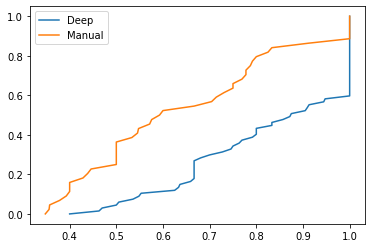

In [226]:
def majority_class_distributions(c1, c2):
    majority_c1 = []
    for key in c1.keys():
        current_conditions = c1[key]
        cnames, ccounts = np.unique(current_conditions, return_counts=True)
        total = sum(ccounts)
        majority = max(ccounts)
        ratio = majority / total 
        majority_c1.append(ratio)

    majority_c2 = []
    for key in c2.keys():
        current_conditions = c2[key]
        cnames, ccounts = np.unique(current_conditions, return_counts=True)
        total = sum(ccounts)
        majority = max(ccounts)
        ratio = majority / total 
        majority_c2.append(ratio)


    majority_c1 = np.sort(majority_c1)
    majority_c2 = np.sort(majority_c2)
    y1 = np.linspace(0, 1, len(majority_c1))
    y2 = np.linspace(0, 1, len(majority_c2))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(majority_c1, y1, label="Deep")
    ax.plot(majority_c2, y2, label="Manual")
    plt.legend()
    plt.show()

majority_class_distributions(c1=deep_conditions, c2=manual_conditions)


### Manual subtypes --> Deep subtypes

In [177]:
deepidx_to_key = {i: k for i, k in enumerate(deep_subtypes.keys())}
manualidx_to_key = {i: k for i, k in enumerate(manual_subtypes.keys())}
condition_to_key = {k: i for i, k in enumerate(["Block", "48hTTX", "0MgGlyBic", "GluGly"])}
key_to_condition = {v: k for k, v in condition_to_key.items()}

def compute_mapping_matrix(features, subtypes, conditions=None, split_regions: bool = False, threshold=0.4):
    subtypes_array = np.array(list(subtypes.values())) 
    subtypes_array = np.reshape(subtypes_array, (subtypes_array.shape[0], -1)) 
    mapping_matrix = np.zeros((len(list(features.keys())), subtypes_array.shape[0]))
    condition_array = []
    condition_names = []
    for k, key in enumerate(features.keys()): 
        data = features[key][0]
        if conditions is not None:
            c = conditions[key]
            condition_names.append(c)
            cidx = condition_to_key[c]
            condition_array.append(cidx)
        N = data.shape[0]
        mapped_to = [0] * subtypes_array.shape[0]
        for i in range(data.shape[0]):
            vector = data[i][np.newaxis, ...] 
            distance_matrix = distance.cdist(vector, subtypes_array, metric="cosine")
            distances = np.argsort(distance_matrix, axis=1)[0]
            mapped_idx = distances[0]
            mapped_to[mapped_idx] += 1
        mapped_to = [item/N for item in mapped_to] 
        mapping_matrix[k] = mapped_to
    
    if conditions is not None:
        sorted_conditions = np.argsort(condition_array)
        mapping_matrix = mapping_matrix[sorted_conditions, :]
        mapping_matrix = mapping_matrix[:, sorted_conditions]

        # for i, c in enumerate(sorted_conditions):
        #     print(i, condition_names[c])
            
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    matrix_copy = mapping_matrix.copy()
    np.fill_diagonal(matrix_copy, 0)
    if split_regions == "deep":
        # Block
        block_block_mass = matrix_copy[:14, :14].sum()
        block_mass = matrix_copy[:14, :].sum()
        print(f"Block mass transported to block: {block_block_mass/block_mass*100:.1f}%")
        ax.axvline(x=14, ymin=0, ymax=14, color="grey", linestyle="--")
        ax.axhline(y=14, xmin=0, xmax=14, color="grey", linestyle="--")

        # 48hTTX 
        ttx_ttx_mass = matrix_copy[14:35, 14:35].sum()
        ttx_mass = matrix_copy[14:35, :].sum()
        print(f"48hTTX mass transported to 48hTTX: {ttx_ttx_mass/ttx_mass*100:.1f}%")
        ax.axvline(x=35, ymin=0, ymax=35, color="tab:red", linestyle="--")
        ax.axhline(y=35, xmin=0, xmax=35, color="tab:red", linestyle="--")

        low_low_mass = matrix_copy[:35, :35].sum()
        low_mass = matrix_copy[:35, :].sum()
        print(f"Low mass transported to low: {low_low_mass/low_mass*100:.1f}%")
        ax.axvline(x=35, ymin=0, ymax=35, color="tab:red", linestyle="--")
        ax.axhline(y=35, xmin=0, xmax=35, color="tab:red", linestyle="--")

        # 0MgGlyBic
        mg_mg_mass = matrix_copy[35:57, 35:57].sum()
        mg_mass = matrix_copy[35:57, :].sum()
        print(f"0MgGlyBic mass transported to 0MgGlyBic: {mg_mg_mass/mg_mass*100:.1f}%")
        ax.axvline(x=57, ymin=0, ymax=57, color="tab:blue", linestyle="--")
        ax.axhline(y=57, xmin=0, xmax=57, color="tab:blue", linestyle="--")
        
        # GluGly
        glu_glu_mass = matrix_copy[57:, 57:].sum()
        glu_mass = matrix_copy[57:, :].sum()
        print(f"GluGly mass transported to GluGly: {glu_glu_mass/glu_mass*100:.1f}%")

        high_high_mass = matrix_copy[35:, 35:].sum()
        high_mass = matrix_copy[35:, :].sum()
        print(f"High mass transported to high: {high_high_mass/high_mass*100:.1f}%")
        ax.axvline(x=35, ymin=0, ymax=35, color="tab:red", linestyle="--")
        ax.axhline(y=35, xmin=0, xmax=35, color="tab:red", linestyle="--")
        
    elif split_regions == "manual":
        # Block
        block_block_mass = matrix_copy[:12, :12].sum()
        block_mass = matrix_copy[:12, :].sum()
        print(f"Block mass transported to block: {block_block_mass/block_mass*100:.1f}%")
        ax.axvline(x=12, ymin=0, ymax=12, color="grey", linestyle="--")
        ax.axhline(y=12, xmin=0, xmax=12, color="grey", linestyle="--")

        # 48hTTX 
        ttx_ttx_mass = matrix_copy[12:28, 12:28].sum()
        ttx_mass = matrix_copy[12:28, :].sum()
        print(f"48hTTX mass transported to 48hTTX: {ttx_ttx_mass/ttx_mass*100:.1f}%")
        ax.axvline(x=28, ymin=0, ymax=28, color="tab:red", linestyle="--")
        ax.axhline(y=28, xmin=0, xmax=28, color="tab:red", linestyle="--")

        low_low_mass = matrix_copy[:28, :28].sum()
        low_mass = matrix_copy[:28, :].sum()
        print(f"Low mass transported to low: {low_low_mass/low_mass*100:.1f}%")
        ax.axvline(x=28, ymin=0, ymax=28, color="tab:red", linestyle="--")
        ax.axhline(y=28, xmin=0, xmax=28, color="tab:red", linestyle="--")

        # 0MgGlyBic
        mg_mg_mass = matrix_copy[28:41, 28:41].sum()
        mg_mass = matrix_copy[28:41, :].sum()
        print(f"0MgGlyBic mass transported to 0MgGlyBic: {mg_mg_mass/mg_mass*100:.1f}%")
        ax.axvline(x=41, ymin=0, ymax=41, color="tab:blue", linestyle="--")
        ax.axhline(y=41, xmin=0, xmax=41, color="tab:blue", linestyle="--")

        # GluGly
        glu_glu_mass = matrix_copy[41:, 41:].sum()
        glu_mass = matrix_copy[41:, :].sum()
        print(f"GluGly mass transported to GluGly: {glu_glu_mass/glu_mass*100:.1f}%")

        high_high_mass = matrix_copy[28:, 28:].sum()
        high_mass = matrix_copy[28:, :].sum()
        print(f"High mass transported to high: {high_high_mass/high_mass*100:.1f}%")
        ax.axvline(x=28, ymin=0, ymax=28, color="tab:red", linestyle="--")
        ax.axhline(y=28, xmin=0, xmax=28, color="tab:red", linestyle="--")
   
    ax.imshow(mapping_matrix, cmap="RdPu", vmin=0, vmax=threshold)
    good_mapping = mapping_matrix > threshold
    ax.set_title(f"{good_mapping.sum()}/{mapping_matrix.shape[0]} ({good_mapping.sum()/mapping_matrix.shape[0]*100:.1f}%) mappings > {threshold*100}%")
    plt.show()
    plt.close(fig)
    return mapping_matrix



=== MANUAL TO DEEP ===


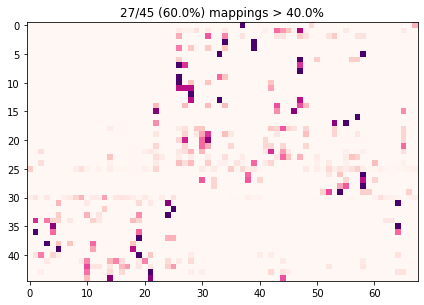

=== DEEP TO MANUAL ===


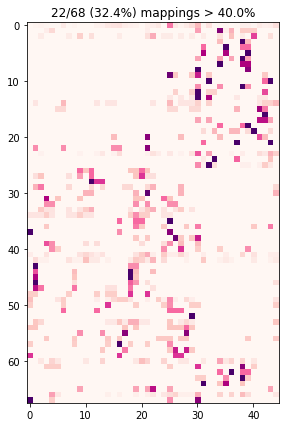

=== DEEP TO DEEP ===
Block mass transported to block: 22.0%
48hTTX mass transported to 48hTTX: 71.3%
Low mass transported to low: 74.6%
0MgGlyBic mass transported to 0MgGlyBic: 55.6%
GluGly mass transported to GluGly: 28.5%
High mass transported to high: 84.3%


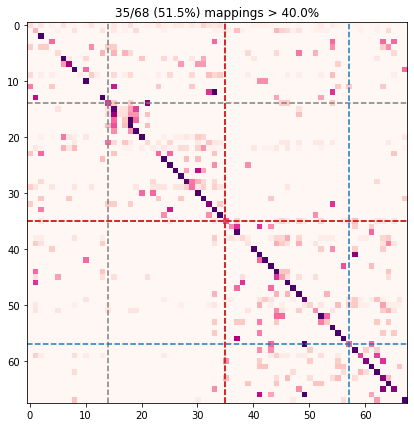

=== MANUAL TO MANUAL ===
Block mass transported to block: 40.2%
48hTTX mass transported to 48hTTX: 55.8%
Low mass transported to low: 72.6%
0MgGlyBic mass transported to 0MgGlyBic: 48.9%
GluGly mass transported to GluGly: 25.2%
High mass transported to high: 63.2%


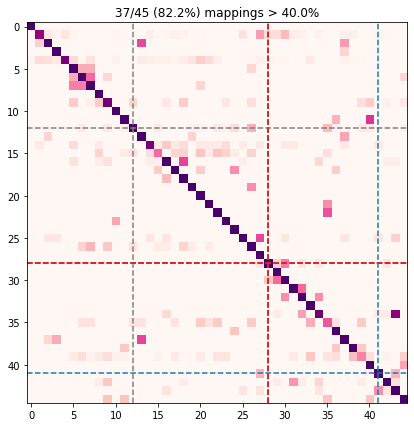

In [178]:
print("=== MANUAL TO DEEP ===")
manual_to_deep = compute_mapping_matrix(features=manual_features, subtypes=deep_subtypes, threshold=0.4)

print("=== DEEP TO MANUAL ===")
deep_to_manual = compute_mapping_matrix(features=deep_features, subtypes=manual_subtypes, threshold=0.4)

print("=== DEEP TO DEEP ===")
deep_to_deep = compute_mapping_matrix(features=deep_features, subtypes=deep_subtypes, conditions=deep_majority_conditions, split_regions="deep", threshold=0.4)

print("=== MANUAL TO MANUAL ===")
manual_to_manual = compute_mapping_matrix(features=manual_features, subtypes=manual_subtypes, conditions=manual_majority_conditions, split_regions="manual", threshold=0.4)



#### Quick check of the majority class per node

In [75]:
for i in range(deep_to_deep.shape[0]):
    key = deepidx_to_key[i]
    condition = deep_majority_conditions[key]
    print(f"{i}: {key} ({condition})")

0: 10101 (Block)
1: 101020101 (0MgGlyBic)
2: 101020102 (GluGly)
3: 1010202010101 (0MgGlyBic)
4: 1010202010102 (0MgGlyBic)
5: 10102020102 (0MgGlyBic)
6: 1010202020101 (GluGly)
7: 1010202020102 (GluGly)
8: 10102020202 (0MgGlyBic)
9: 10201010101010101 (48hTTX)
10: 10201010101010102 (48hTTX)
11: 10201010101010201 (Block)
12: 10201010101010202 (Block)
13: 1020101010102 (Block)
14: 1020101010201 (48hTTX)
15: 10201010102020101 (48hTTX)
16: 10201010102020102 (48hTTX)
17: 102010101020202 (48hTTX)
18: 1020101020101 (0MgGlyBic)
19: 1020101020102 (GluGly)
20: 102010102020101 (48hTTX)
21: 102010102020102 (Block)
22: 1020101020202 (48hTTX)
23: 1020102 (48hTTX)
24: 1020201 (GluGly)
25: 1020202 (48hTTX)
26: 2010101010101 (0MgGlyBic)
27: 201010101010201 (0MgGlyBic)
28: 201010101010202 (0MgGlyBic)
29: 2010101010201 (Block)
30: 2010101010202 (0MgGlyBic)
31: 201010102010101 (GluGly)
32: 201010102010102 (GluGly)
33: 2010101020102 (0MgGlyBic)
34: 20101010202 (0MgGlyBic)
35: 2010102010101 (0MgGlyBic)
36: 201

In [76]:
for i in range(manual_to_manual.shape[0]):
    key = manualidx_to_key[i]
    condition = manual_majority_conditions[key]
    print(f"{i}: {key} ({condition})")

0: 101 (Block)
1: 10201010101 (48hTTX)
2: 1020101010201 (0MgGlyBic)
3: 1020101010202 (0MgGlyBic)
4: 102010102010101 (0MgGlyBic)
5: 102010102010102 (Block)
6: 1020101020102 (48hTTX)
7: 10201010202010101 (Block)
8: 10201010202010102 (48hTTX)
9: 102010102020102 (0MgGlyBic)
10: 1020101020202010101 (GluGly)
11: 1020101020202010102 (0MgGlyBic)
12: 10201010202020102 (Block)
13: 102010102020202 (48hTTX)
14: 1020102010101010101 (48hTTX)
15: 1020102010101010102 (48hTTX)
16: 10201020101010102 (48hTTX)
17: 102010201010102 (48hTTX)
18: 1020102010102 (48hTTX)
19: 1020102010201 (Block)
20: 102010201020201 (Block)
21: 102010201020202 (Block)
22: 1020102020101 (Block)
23: 1020102020102 (48hTTX)
24: 10201020202 (0MgGlyBic)
25: 1020201 (Block)
26: 102020201 (0MgGlyBic)
27: 1020202020101 (Block)
28: 1020202020102 (48hTTX)
29: 10202020202 (Block)
30: 201 (Block)
31: 202010101 (0MgGlyBic)
32: 20201010201 (48hTTX)
33: 20201010202 (GluGly)
34: 20201020101 (0MgGlyBic)
35: 2020102010201 (0MgGlyBic)
36: 20201020

#### Deep features not correctly assigned to subtype based on manual features

In [43]:
total = 0
for i in range(deep_to_deep.shape[0]):
    row = deep_to_deep[i]
    current_id = deepidx_to_key[i]
    mapped_to = np.argmax(row)
    mapped_id = deepidx_to_key[mapped_to]
    if current_id != mapped_id:
        print(f"({i}) {current_id} -> ({mapped_to}) {mapped_id}\t {deep_to_deep[i, mapped_to]*100:.1f}%")
        total += 1
print(f"Total: {total}")


(0) 10101 -> (9) 10201010101010101	 7.5%
(6) 1010202020101 -> (1) 101020101	 42.9%
(23) 1020102 -> (9) 10201010101010101	 15.9%
(27) 201010101010201 -> (26) 2010101010101	 25.0%
(29) 2010101010201 -> (30) 2010101010202	 18.8%
(33) 2010101020102 -> (31) 201010102010101	 17.4%
(34) 20101010202 -> (26) 2010101010101	 16.7%
(36) 2010102010102 -> (8) 10102020202	 18.2%
(41) 20101020202 -> (28) 201010101010202	 13.3%
(42) 2010201 -> (26) 2010101010101	 12.1%
(45) 201020201010202 -> (44) 201020201010201	 50.0%
(46) 20102020102 -> (47) 20102020201	 31.6%
(48) 20102020202 -> (53) 202010201	 33.3%
(49) 202010101 -> (37) 2010102010201	 10.6%
(50) 2020101020101 -> (31) 201010102010101	 16.7%
(51) 2020101020102 -> (32) 201010102010102	 20.0%
(53) 202010201 -> (48) 20102020202	 19.4%
(54) 202010202010101 -> (52) 20201010202	 20.0%
(56) 2020102020102 -> (47) 20102020201	 27.3%
(59) 202010202020202 -> (58) 202010202020201	 50.0%
(62) 2020201010202 -> (1) 101020101	 40.0%
(63) 2020201020101 -> (8) 1010

In [29]:
from scipy.cluster import hierarchy
import matplotlib


def hierarchical_clustering(D, scale=0.8, threshold=0.4):
    distances = distance.cdist(D, D)
    mask = np.triu(np.ones_like(distances, dtype=bool)) * np.invert(np.eye(len(distances), dtype=bool))
    dendrogram_distance = np.quantile(distances[mask], q=0.25)
    
    Y = hierarchy.linkage(D, method="average", metric="euclidean")
    Y2 = hierarchy.linkage(D.T, method="average", metric="euclidean") 
    labels = hierarchy.fcluster(Y, dendrogram_distance, "distance")
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_axes([0, 0, 0.1, scale])
    ax1.set_xticks([])
    ax1.set_yticks([])
    fig.gca().invert_yaxis()
    ax1.axis("off")

    cmap = plt.get_cmap("Set2", (labels.max()).item())
    hierarchy.set_link_color_palette([matplotlib.colors.to_hex(cmap(i+1)) for i in range(labels.max())])
    Z1 = hierarchy.dendrogram(
        Y,
        orientation="left",
        color_threshold=dendrogram_distance,
        above_threshold_color="silver",
        ax=ax1
    )
    Z2 = hierarchy.dendrogram(
        Y2,
        orientation="left",
        color_threshold=dendrogram_distance,
        above_threshold_color="silver",
        no_plot=True
    )


    axmatrix = fig.add_axes([0.15, 0, 0.75, scale])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']

    sorted_co_matrix = D[idx1, :]
    sorted_co_matrix = sorted_co_matrix[:, idx2]
    im = axmatrix.matshow(sorted_co_matrix, aspect="equal", origin="lower", cmap="RdPu", vmin=0, vmax=threshold)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    fig.gca().invert_xaxis()

    plt.show()


In [30]:
# hierarchical_clustering(D=deep_to_manual)
# hierarchical_clustering(D=manual_to_deep)

In [31]:
def get_specific_node(root, node_id, node=None):
    for child in root.children:
        # print(child.cluster_id, child.cluster_id == 10101)
        if child.cluster_id == node_id:
            node = child
        else:
            found_node = get_specific_node(root=child, node_id=node_id, node=node)
            if found_node is not None:
                return found_node
    return node

In [32]:
def threshold_matrix(matrix, threshold=0.4, direction="manual"):
    indices = np.where(matrix > threshold)

    max_mapping = np.max(matrix, axis=1)
    common_ids = np.where(max_mapping >= threshold)[0]
    other_ids = []
    for idx in common_ids:
        row = matrix[idx]
        other_ids.append(np.argmax(row))
    
    # print(f"=== To {direction} mapping ===")

    threshold_mask = matrix < threshold
    thresholded_matrix = matrix.copy()
    thresholded_matrix[threshold_mask] = 0
    num_satisfied = 0


    for i, j in zip(indices[0], indices[1]):
        if direction == "manual":
            source_id = deepidx_to_key[i]
            target_id = manualidx_to_key[j]
            node = get_specific_node(deep_tree, source_id)
            leaf_nodes = find_leaf_nodes(node)
            num_images = sum([n.data["data"].shape[0] for n in leaf_nodes])
            # if num_images < 10:
            #     continue
            num_satisfied += 1
            num_moved = int(num_images * matrix[i, j])
            print(f"\t{source_id} ({i}) -> ({j}) {target_id} ({matrix[i, j]*100:.1f}%) ; {num_moved}/{num_images} moved")
        else:
            source_id = manualidx_to_key[i]
            target_id = deepidx_to_key[j]
            node = get_specific_node(manual_tree, source_id)
            leaf_nodes = find_leaf_nodes(node)
            num_images = sum([n.data["data"].shape[0] for n in leaf_nodes])
            # if num_images < 10:
            #     continue
            num_satisfied += 1
            num_moved = int(num_images * matrix[i, j])
            print(f"\t{source_id} ({i}) -> ({j}) {target_id} ({matrix[i, j]*100:.1f}%) ; {num_moved}/{num_images} moved")

    print(f"\t[---] {num_satisfied} mappings satisfied conditions")
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.imshow(thresholded_matrix, cmap="RdPu", vmin=0, vmax=1)
    plt.show()
    return common_ids, np.array(other_ids)

=== MANUAL TO DEEP ===
	101 (0) -> (37) 2010102010201 (81.2%) ; 13/16 moved
	1020101010202 (3) -> (34) 20101010202 (50.0%) ; 1/2 moved
	1020101010202 (3) -> (39) 2010102020101 (50.0%) ; 1/2 moved
	102010102010101 (4) -> (39) 2010102020101 (54.5%) ; 6/11 moved
	102010102010102 (5) -> (33) 2010101020102 (50.0%) ; 1/2 moved
	102010102010102 (5) -> (58) 202010202020201 (50.0%) ; 1/2 moved
	1020101020102 (6) -> (47) 20102020201 (66.7%) ; 8/12 moved
	10201010202010101 (7) -> (26) 2010101010101 (50.0%) ; 4/8 moved
	10201010202010102 (8) -> (47) 20102020201 (100.0%) ; 6/6 moved
	102010102020102 (9) -> (26) 2010101010101 (70.0%) ; 7/10 moved
	1020101020202010101 (10) -> (26) 2010101010101 (70.0%) ; 7/10 moved
	10201010202020102 (12) -> (28) 201010101010202 (100.0%) ; 2/2 moved
	102010102020202 (13) -> (33) 2010101020102 (42.9%) ; 3/7 moved
	10201020101010102 (16) -> (57) 2020102020201 (100.0%) ; 2/2 moved
	102010201010102 (17) -> (55) 202010202010102 (50.0%) ; 3/6 moved
	102020201 (26) -> (58) 

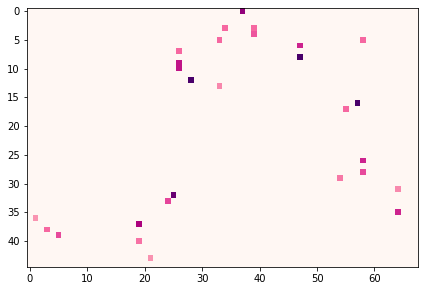

=== DEEP TO MANUAL ===
	1010202010101 (3) -> (38) 20201020201 (77.8%) ; 7/9 moved
	1010202020101 (6) -> (38) 20201020201 (42.9%) ; 3/7 moved
	10102020202 (8) -> (30) 201 (66.7%) ; 2/3 moved
	10201010101010201 (11) -> (38) 20201020201 (50.0%) ; 3/6 moved
	10201010101010202 (12) -> (30) 201 (46.2%) ; 6/13 moved
	1020101010102 (13) -> (30) 201 (50.0%) ; 15/30 moved
	10201010102020102 (16) -> (42) 20202010202 (100.0%) ; 2/2 moved
	1020101020101 (18) -> (39) 20201020202 (60.0%) ; 3/5 moved
	1020101020102 (19) -> (40) 202020101 (47.1%) ; 8/17 moved
	1020201 (24) -> (33) 20201010202 (66.7%) ; 26/39 moved
	1020202 (25) -> (32) 20201010201 (59.3%) ; 35/59 moved
	201010101010202 (28) -> (11) 1020101020202010102 (50.0%) ; 2/4 moved
	2010102010201 (37) -> (0) 101 (50.0%) ; 3/6 moved
	2010202010101 (43) -> (1) 10201010101 (66.7%) ; 4/6 moved
	201020201010201 (44) -> (18) 1020102010102 (44.4%) ; 4/9 moved
	201020201010202 (45) -> (18) 1020102010102 (50.0%) ; 5/10 moved
	20102020102 (46) -> (1) 10201

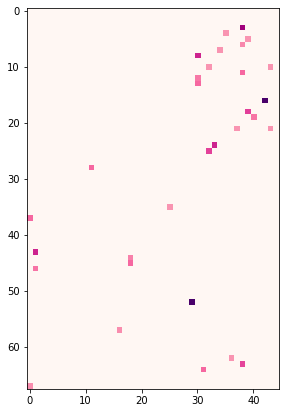

In [195]:
print("=== MANUAL TO DEEP ===")
common_manual, other_manual = threshold_matrix(matrix=manual_to_deep, threshold=0.4, direction="deep")
common_manual = [manualidx_to_key[item] for item in common_manual]
other_manual = [deepidx_to_key[item] for item in other_manual]

np.savez(file="./common_manual", common=common_manual, other=other_manual)


print("=== DEEP TO MANUAL ===")
common_deep, other_deep = threshold_matrix(matrix=deep_to_manual, threshold=0.4, direction="manual")
common_deep = [deepidx_to_key[item] for item in common_deep]
other_deep = [manualidx_to_key[item] for item in other_deep]

np.savez(file="./common_deep", common=common_deep, other=other_deep)

In [211]:
from scipy.stats import gaussian_kde

def find_unique_nodes(matrix, threshold=0.15, direction="manual", figax=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    max_mapping = np.max(matrix, axis=1)
    print(max_mapping.shape)
    N = max_mapping.shape[0]
    unique_ids = np.where(max_mapping <= threshold)[0]
    print(len(unique_ids))
    proportion_unique = len(unique_ids) / N 
    sorted_mappings = np.sort(max_mapping) 

    # normalized_cumulative = cumulative_sum / cumulative_sum[-1]
    ax.plot(sorted_mappings, np.linspace(0, 1, len(sorted_mappings)), label="deep" if direction == "manual" else "manual")
    # kernel = gaussian_kde(max_mapping)
    # x = np.linspace(0, 1, 100)
    # ax.plot(x, kernel(x), label="deep" if direction == "manual" else "manual")
    # ax.fill_between(x, kernel(x), alpha=0.2)
    return fig, ax, unique_ids, proportion_unique



(68,)
46
(45,)
20


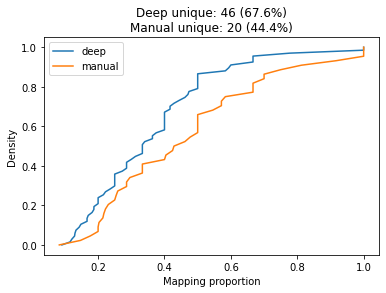

In [217]:

fig, ax, unique_deep, proportion_unique_deep = find_unique_nodes(matrix=deep_to_manual, threshold=0.4, direction="manual")
fig, ax, unique_manual, proportion_unique_manual = find_unique_nodes(matrix=manual_to_deep, threshold=0.4, figax=(fig, ax), direction="deep")
ax.set_xlabel("Mapping proportion")
ax.set_ylabel("Density")
ax.set_title(f"Deep unique: {len(unique_deep)} ({proportion_unique_deep*100:.1f}%)\nManual unique: {len(unique_manual)} ({proportion_unique_manual*100:.1f}%)")
plt.legend()
plt.show()

In [198]:

unique_deep = [deepidx_to_key[item] for item in unique_deep]
unique_manual = [manualidx_to_key[item] for item in unique_manual]
np.savez(file="./unique_deep", unique=unique_deep)
np.savez(file="./unique_manual", unique=unique_manual)

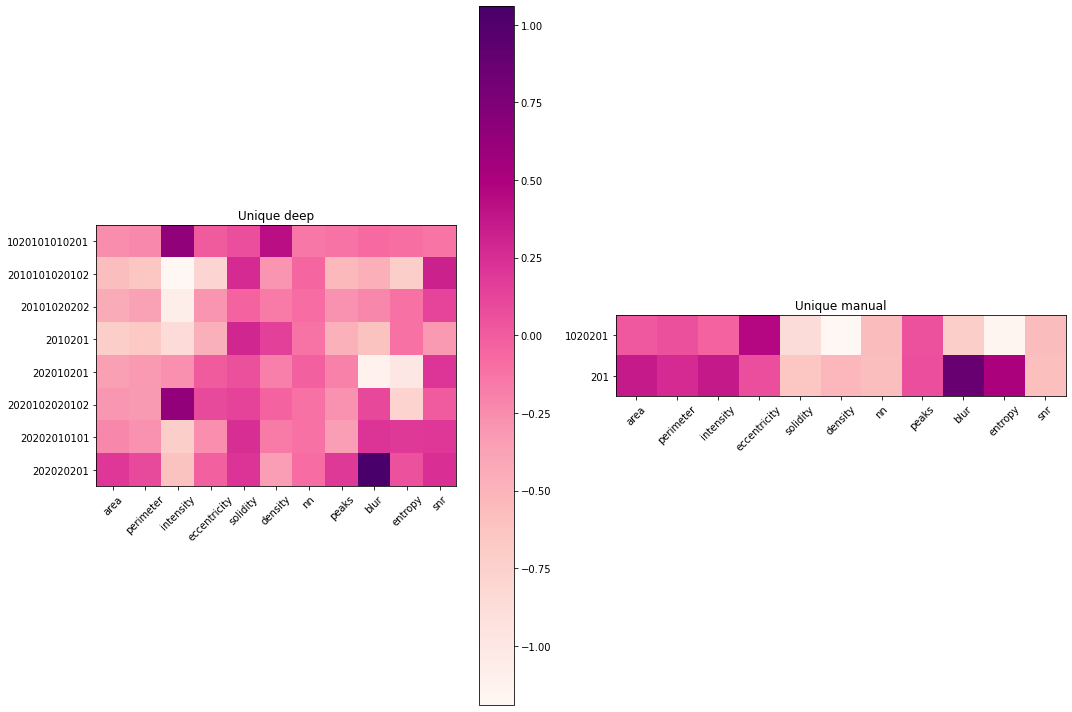

In [199]:
unique_deep_features = []
unique_manual_features = []
FEATURES = ["area", "perimeter", "intensity", "eccentricity", "solidity", "density", "nn", "peaks", "blur", "entropy", "snr"]
for node_id in unique_deep:
    node_features = deep_features[node_id][0]
    node_features = np.mean(node_features, axis=0)
    unique_deep_features.append(node_features)

for node_id in unique_manual:
    node_features = manual_features[node_id][0]
    node_features = np.mean(node_features, axis=0)
    unique_manual_features.append(node_features)

# unique_features = (unique_features - min_features) / (max_features - min_features)
# print(np.min(unique_features, axis=0), np.max(unique_features, axis=0))
max_value = np.max(unique_deep_features)
fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs[0].imshow(unique_deep_features, cmap="RdPu", vmax=max_value)
axs[0].set_xticks(np.arange(len(FEATURES)))
axs[0].set_yticks(np.arange(len(unique_deep_features)))
axs[0].set_xticklabels(FEATURES, rotation=45)
axs[0].set_yticklabels(unique_deep)
axs[1].imshow(unique_manual_features, cmap="RdPu", vmax=max_value) # , vmax=max_value)
axs[1].set_xticks(np.arange(len(FEATURES)))
axs[1].set_yticks(np.arange(len(unique_manual_features)))
axs[1].set_xticklabels(FEATURES, rotation=45)
axs[1].set_yticklabels(unique_manual)
axs[0].set_title("Unique deep")
axs[1].set_title("Unique manual")
plt.colorbar(axs[0].imshow(unique_deep_features, cmap="RdPu"), ax=axs[0])
# plt.colorbar(axs[1].imshow(unique_manual_features, cmap="RdPu"), ax=axs[1])
plt.tight_layout()
plt.show()




NameError: name 'total_block' is not defined

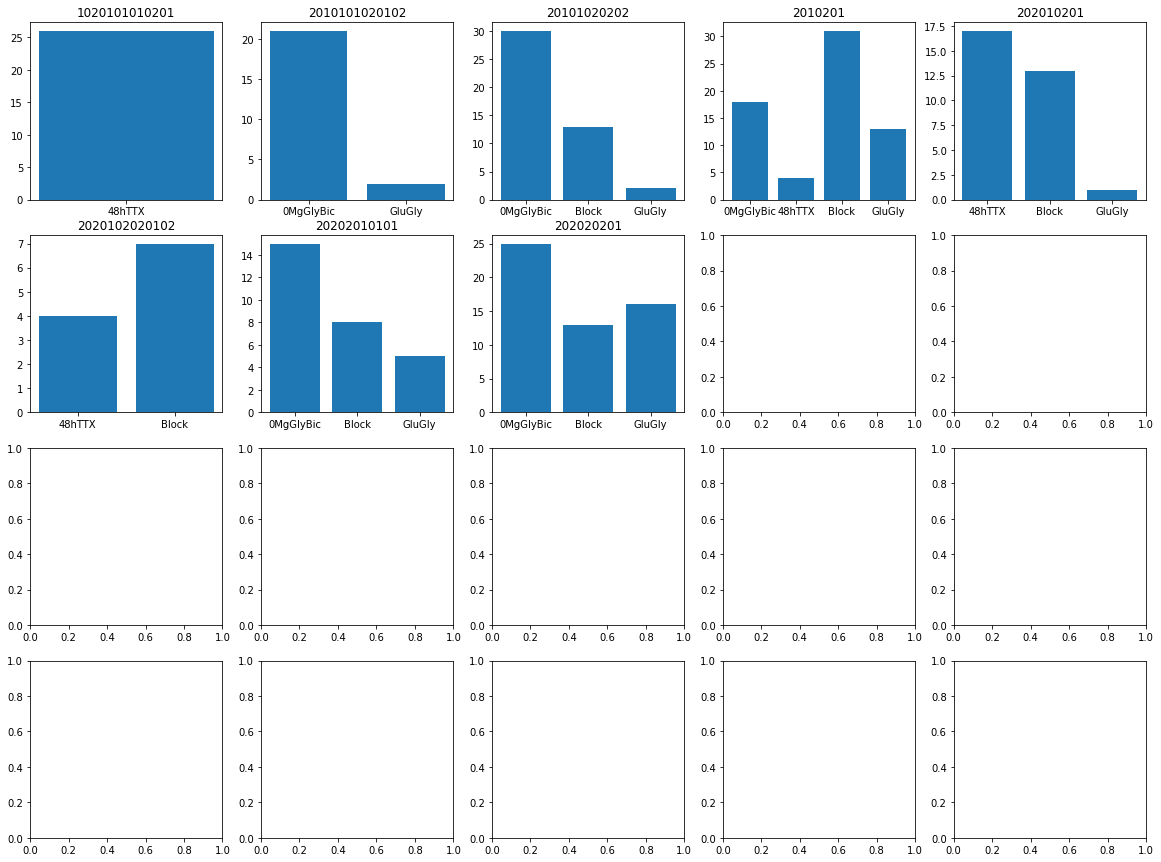

In [200]:
fig, axs = plt.subplots(4, 5, figsize=(20, 15))
partial = {"Block": 0, "48hTTX": 0, "0MgGlyBic": 0, "GluGly": 0}
for i, node_id in enumerate(unique_deep):
    ax = axs.ravel()[i]
    conditions = deep_conditions[node_id]
    condition_names, condition_counts = np.unique(conditions, return_counts=True)
    for cn, cc in zip(condition_names, condition_counts):
        partial[cn] += cc
    ax.bar(x=condition_names, height=condition_counts)
    ax.set_xticks(np.arange(len(condition_names)), condition_names)
    ax.set_title(node_id)

partial["Block"] /= total["Block"]
partial["48hTTX"] /= total["48hTTX"]
partial["0MgGlyBic"] /= total["0MgGlyBic"]
partial["GluGly"] /= total["GluGly"]
axs.ravel()[-1].bar(x=list(total.keys()), height=list(total.values()))
plt.tight_layout()
plt.show()
plt.close(fig)

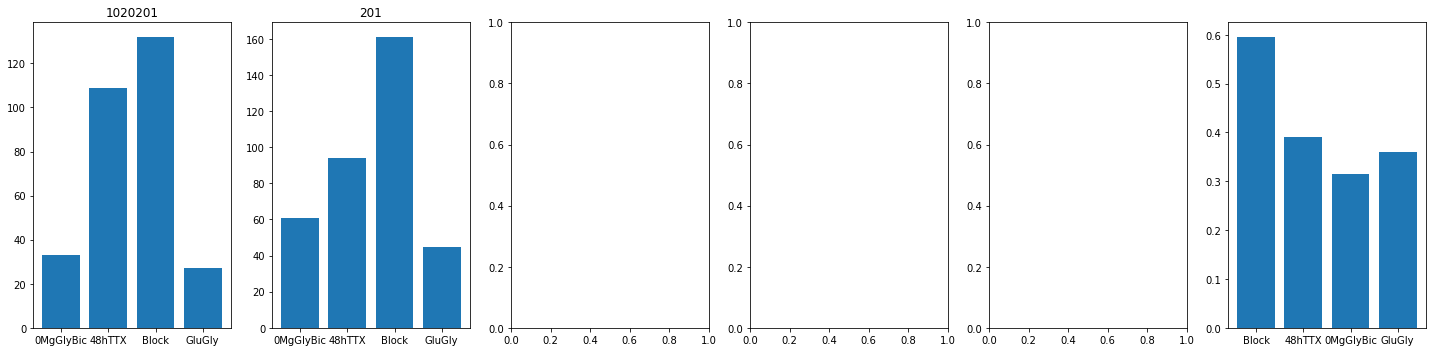

In [93]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
total = {"Block": 0, "48hTTX": 0, "0MgGlyBic": 0, "GluGly": 0}
for i, node_id in enumerate(unique_manual):
    ax = axs.ravel()[i]
    conditions = manual_conditions[node_id]
    condition_names, condition_counts = np.unique(conditions, return_counts=True)
    for cn, cc in zip(condition_names, condition_counts):
        total[cn] += cc
    ax.bar(x=condition_names, height=condition_counts)
    ax.set_xticks(np.arange(len(condition_names)), condition_names)
    ax.set_title(node_id)
total["Block"] /= total_block
total["48hTTX"] /= total_ttx
total["0MgGlyBic"] /= total_0mg
total["GluGly"] /= total_glu
axs.ravel()[-1].bar(x=list(total.keys()), height=list(total.values()))
plt.tight_layout()
plt.show()
plt.close(fig)